# ML model

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from train_test_split import site_train_val_test_split

sns.set_palette("colorblind")

In [3]:
df = pd.read_csv('../data/merged_data_cleaned.csv', low_memory=False)
target = pd.read_csv('../data/target.csv')
target.columns = target.columns.str.lower()

# Rename target["csfractures"] to target["csi"]
target.rename(columns={"csfractures": "csi"}, inplace=True)

print(df.shape, target.shape)

(3314, 620) (3314, 2)


In [4]:
# Eliminate any column is object type
df = df.select_dtypes(exclude=['object'])

# Change -1 to 0
df = df.replace(-1, 0)

# Drop sectiongcsavailable
df = df.drop(columns='sectiongcsavailable')

In [5]:
# Reorder the rows of target given the order of df studysubjectid
target = target.set_index('studysubjectid').loc[df['studysubjectid']].reset_index()

In [6]:
assert df['studysubjectid'].equals(target['studysubjectid'])

In [7]:
# Extract the feature names
df_feat = df.drop(columns=["site", "caseid", "studysubjectid"])

# Eliminate "ageinyears"
df.drop(columns=["ageinyears"], inplace=True)

In [8]:
# Fill -1 with 0
df.fillna(0, inplace=True)

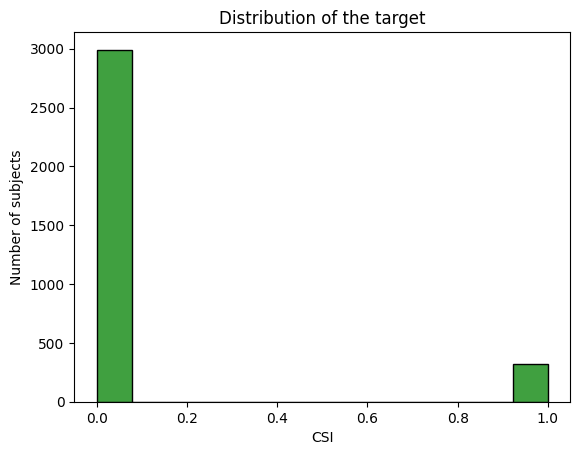

Proportion of subjects with CSI = 1: 0.0971635485817743


In [9]:
# Plot the distribution of the target
sns.histplot(target['csi'], color='green')
plt.title('Distribution of the target')
plt.xlabel('CSI')
plt.ylabel('Number of subjects')

plt.show()

# Print the proportion of subjects with CSI = 1
print('Proportion of subjects with CSI = 1:', target['csi'].mean())

In [10]:
# Split the data into train, validation and test sets
train_df, val_df, test_df, train_target, val_target, test_target = site_train_val_test_split(df, target, random_state=42)

In [11]:
# Print the proportion of subjects with 1 in the train, validation and test sets
print('Proportion of subjects with CSI = 1 in the train set:', train_target.mean())
print('Proportion of subjects with CSI = 1 in the validation set:', val_target.mean())
print('Proportion of subjects with CSI = 1 in the test set:', test_target.mean())

Proportion of subjects with CSI = 1 in the train set: 0.095512554
Proportion of subjects with CSI = 1 in the validation set: 0.100961536
Proportion of subjects with CSI = 1 in the test set: 0.102345414


# Metrics

In [12]:
# Metris are F1 score, precision, recall, accuracy, AUC, and confusion matrix
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, roc_auc_score, confusion_matrix, balanced_accuracy_score

def print_metrics(y_true, y_pred):
    metrics = {
        'F1 score': f1_score(y_true, y_pred, average='weighted'),
        'Precision': precision_score(y_true, y_pred, average='weighted'),
        'Recall': recall_score(y_true, y_pred, average='weighted'),
        'Accuracy': balanced_accuracy_score(y_true, y_pred),
        'AUC': roc_auc_score(y_true, y_pred)
    }
    print('Metrics:')
    for metric, value in metrics.items():
        print(f'{metric}: {value}')

    print('Confusion matrix:')
    print(confusion_matrix(y_true, y_pred))
    return metrics

In [13]:
# Define metric for training as balanced F1 score
from sklearn.metrics import make_scorer

balanced_f1 = make_scorer(f1_score, pos_label=1, average='weighted')

sample_weight = np.where(train_target == 1, 10, 1)

# Logistic regression

In [14]:
# Contains Nan values
train_df = np.nan_to_num(train_df, nan=0)
val_df = np.nan_to_num(val_df, nan=0)
test_df = np.nan_to_num(test_df, nan=0)

In [15]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight='balanced')

model.fit(train_df, train_target, sample_weight=sample_weight)

train_pred = model.predict(train_df)
val_pred = model.predict(val_df)
test_pred = model.predict(test_df)

c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
# Print the metrics for the train set
print('Train set:')
train_metrics = print_metrics(train_target, train_pred)

# Print the metrics for the validation set
print('Validation set:')
val_metrics = print_metrics(val_target, val_pred)


Train set:
Metrics:
F1 score: 0.5374508178384853
Precision: 0.9186918748878403
Recall: 0.45327295183202965
Accuracy: 0.6977696859353664
AUC: 0.6977696859353664
Confusion matrix:
[[ 869 1328]
 [   0  232]]
Validation set:
Metrics:
F1 score: 0.4798135154920472
Precision: 0.8245425031805629
Recall: 0.3894230769230769
Accuracy: 0.5124777183600713
AUC: 0.5124777183600713
Confusion matrix:
[[134 240]
 [ 14  28]]


In [17]:
# Print the metrics for the test set
print('Test set:')
test_metrics = print_metrics(test_target, test_pred)

Test set:
Metrics:
F1 score: 0.5738619686676003
Precision: 0.8380180155782907
Recall: 0.48187633262260127
Accuracy: 0.5545081155977831
AUC: 0.5545081155977831
Confusion matrix:
[[195 226]
 [ 17  31]]


In [18]:
# Check importance of features
importances = model.coef_[0]

# Select the top 20 features
indices = np.argsort(importances)[::-1][:20]
df_feat.iloc[:, indices].columns

Index(['longtermrehab', 'pttenderneckant', 'bodyasawhole6', 'arrivaltimend',
       'edarrivaltimend', 'medsrecdsed', 'cervicalspineimmobilization',
       'omtspeed', 'posmidnecktenderness2', 'outcomestudysitemobility1',
       'cervicalspineprecautionscc_dup', 'pttendernecklevelc6',
       'ptcomppainabd', 'pttenderneckmid_dup', 'reviewresulteq_as',
       'otherinjuriesext_dup', 'mvcrec', 'otherinjuriesface_dup',
       'reviewresulteq_li', 'xraysviewlt'],
      dtype='object')

# Random Forest

In [19]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42)

model.fit(train_df, train_target)

RandomForestClassifier(random_state=42)

In [20]:
# Predict the target for the train, validation and test sets
train_pred = model.predict(train_df)
val_pred = model.predict(val_df)
test_pred = model.predict(test_df)

In [21]:
# Print the metrics for the train set
print('Train set:')
train_metrics = print_metrics(train_target, train_pred)

# Print the metrics for the validation set
print('Validation set:')
val_metrics = print_metrics(val_target, val_pred)

Train set:
Metrics:
F1 score: 0.9995879101902164
Precision: 0.999588495248684
Recall: 0.9995883079456567
Accuracy: 0.9978448275862069
AUC: 0.9978448275862069
Confusion matrix:
[[2197    0]
 [   1  231]]
Validation set:
Metrics:
F1 score: 0.8512414800389484
Precision: 0.8082701553254439
Recall: 0.8990384615384616
Accuracy: 0.5
AUC: 0.5
Confusion matrix:
[[374   0]
 [ 42   0]]


c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [22]:
# Print the metrics for the test set
print('Test set:')
test_metrics = print_metrics(test_target, test_pred)

Test set:
Metrics:
F1 score: 0.8492417527131597
Precision: 0.80578375257432
Recall: 0.8976545842217484
Accuracy: 0.5
AUC: 0.5
Confusion matrix:
[[421   0]
 [ 48   0]]


c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
# Check importance of features
importances = model.feature_importances_

# Select the top 20 features
indices = np.argsort(importances)[::-1][:20]
df_feat.iloc[:, indices].columns

Index(['estimatetimeinjury', 'formoff', 'medsgiven', 'injurytimend',
       'totalgcsmanual', 'cspineprecautionscc', 'patientsposition', 'loc',
       'xraysviewom_dup', 'fallfromelevation_dup', 'minorinjurieshead',
       'ctperformed_dup', 'cspineprecautions', 'verbalgcs',
       'fielddocumentation', 'xraysviewfe_dup', 'ptcomppainhead',
       'cervicalspineintervrlb', 'minorinjuriesext', 'motorgcs'],
      dtype='object')

# Other model

In [24]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(random_state=42)

model.fit(train_df, train_target)


GradientBoostingClassifier(random_state=42)

In [25]:
# Predict the target for the train, validation and test sets
train_pred = model.predict(train_df)
val_pred = model.predict(val_df)
test_pred = model.predict(test_df)

In [26]:
# Print the metrics for the train set
print('Train set:')
train_metrics = print_metrics(train_target, train_pred)

# Print the metrics for the validation set
print('Validation set:')
val_metrics = print_metrics(val_target, val_pred)

Train set:
Metrics:
F1 score: 0.886607183388648
Precision: 0.9238405737535418
Recall: 0.916838205022643
Accuracy: 0.5646551724137931
AUC: 0.5646551724137931
Confusion matrix:
[[2197    0]
 [ 202   30]]
Validation set:
Metrics:
F1 score: 0.8464229790565668
Precision: 0.8073889096340553
Recall: 0.8894230769230769
Accuracy: 0.4946524064171123
AUC: 0.4946524064171123
Confusion matrix:
[[370   4]
 [ 42   0]]


In [27]:
# Print the metrics for the test set
print('Test set:')
test_metrics = print_metrics(test_target, test_pred)


Test set:
Metrics:
F1 score: 0.8438967390649658
Precision: 0.8047937651643261
Recall: 0.8869936034115139
Accuracy: 0.49406175771971494
AUC: 0.49406175771971494
Confusion matrix:
[[416   5]
 [ 48   0]]


In [28]:
# Check importance of features
importances = model.feature_importances_

# Select the top 20 features
indices = np.argsort(importances)[::-1][:20]
df_feat.iloc[:, indices].columns

Index(['arrivaltimend', 'pttenderchest', 'c3sbfracturela', 'medsgivenglu_dup',
       'estimatetimeinjury', 'formoff', 'fielddocumentation', 'ptcomppainface',
       'mvcrec', 'c3_4sbligfd', 'xraysviewfe_dup', 'omtspeed',
       'edarrivaltimend', 'minorinjuriesback', 'mvcspeed_dup',
       'edarrivaldatend', 'fallfromelevation', 'c5_6sbligfd', 'medsrecdor',
       'pttenderhead_dup'],
      dtype='object')

# Clustering

In [29]:
# Which columns on df_feat are not binary?
non_binary_columns = df_feat.fillna(0).columns[(df_feat.nunique() > 3)]

In [30]:
non_binary_columns

Index(['totalgcsmanual', 'gcseye', 'verbalgcs', 'motorgcs', 'avpudetails',
       'outcomestudysiteneuro', 'outcomestudysitemobility', 'emsestimatetime',
       'patientsposition', 'totalgcsmanual_dup', 'gcseye_dup', 'verbalgcs_dup',
       'motorgcs_dup', 'totalgcs_dup', 'injuryprimarymechanism', 'mvcspeed',
       'fallfromelevation', 'falldownstairs', 'estimatetimeinjury',
       'mvcspeed_dup', 'omtspeed_dup', 'fallfromelevation_dup',
       'falldownstairs_dup', 'headfirstregion', 'reviewresultnumofviews',
       'ageinyears', 'c2sbfractureodtype'],
      dtype='object')

In [31]:
# Hierarchical clustering
from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN
from sklearn.metrics import silhouette_score

In [32]:
df_feat.nunique() 

arrivaltimend                  2
receivedintransfer             2
dxcspineinjury                 2
ptambulatorypriorarrival       3
cervicalspineimmobilization    2
                              ..
signalchangelevelc5            2
signalchangelevelc6            2
signalchangelevelc7            2
cordinjurynoradiographic       2
injurydatetime                 0
Length: 516, dtype: int64

In [33]:
# Select the features
X = df_feat.fillna(0)
column_names = df_feat.columns

# Convert -1 to 0
X = X.replace(-1, 0)

# Only select columns that contains 0 and 1
X = X.loc[:, (X.nunique() == 2)]
X = X.fillna(0)

In [34]:
np.any((X!=0) & (X!=1))

np.False_

In [35]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import pdist

# Calculate the distance matrix
binary_dist = pdist(X.T, metric='hamming')
linkage_matrix = linkage(binary_dist, method='ward')

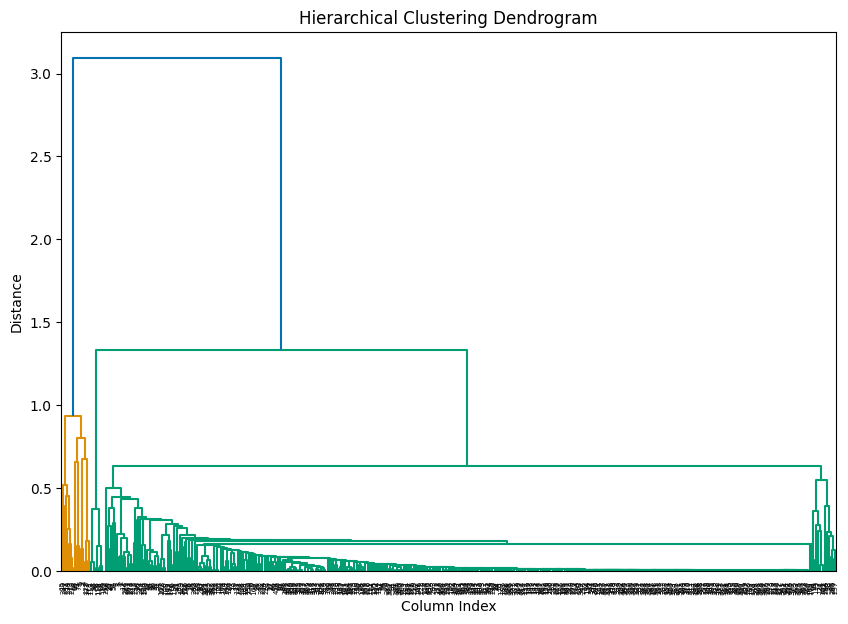

In [36]:
# Plot dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linkage_matrix)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Column Index')
plt.ylabel('Distance')
plt.show()

In [37]:
# Perform hierarchical clustering
n_clusters = 5
model = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')

In [38]:
model.fit(X.T)

AgglomerativeClustering(n_clusters=5)

In [39]:
model.labels_

array([3, 1, 1, 0, 0, 0, 3, 1, 1, 3, 3, 3, 1, 3, 4, 4, 1, 3, 2, 1, 3, 1,
       3, 1, 3, 1, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 3, 1,
       3, 1, 3, 1, 1, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 1,
       3, 3, 0, 0, 3, 3, 0, 0, 3, 3, 3, 3, 1, 3, 1, 3, 3, 1, 1, 1, 3, 3,
       3, 3, 3, 3, 3, 1, 1, 1, 1, 2, 2, 2, 1, 1, 3, 1, 3, 3, 3, 3, 3, 1,
       1, 3, 1, 3, 3, 1, 1, 2, 2, 2, 1, 1, 3, 1, 3, 3, 1, 1, 0, 1, 3, 1,
       3, 1, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3,
       1, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 4, 3, 1, 3, 3, 3, 3, 1, 3, 3, 3, 1, 3, 3, 1, 1, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 1, 4, 4, 4, 4, 1, 1, 1, 1, 1,
       1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 3, 3, 3,

In [40]:
# Create new features from the clusters by joining the columns in the same cluster
cluster_features = []
df_new = df.copy()
for i in range(n_clusters):
    cluster = X.columns[model.labels_ == i]
    cluster_name = f'cluster_{i}'
    df_new[cluster_name] = np.logical_or.reduce(X[cluster], axis=1)
    cluster_features.append(cluster_name)

In [41]:
X_new = df_new[cluster_features]

In [42]:
# Perform Logistic Regression
model = LogisticRegression(class_weight='balanced')

model.fit(X_new, target["csi"])

LogisticRegression(class_weight='balanced')

In [43]:
# Predict
pred = model.predict(X_new)
metrics = print_metrics(target["csi"], pred)

Metrics:
F1 score: 0.7061767551591119
Precision: 0.867094238731232
Recall: 0.6309595654797827
Accuracy: 0.6390395090842661
AUC: 0.6390395090842661
Confusion matrix:
[[1882 1110]
 [ 113  209]]


Text(50.722222222222214, 0.5, 'True')

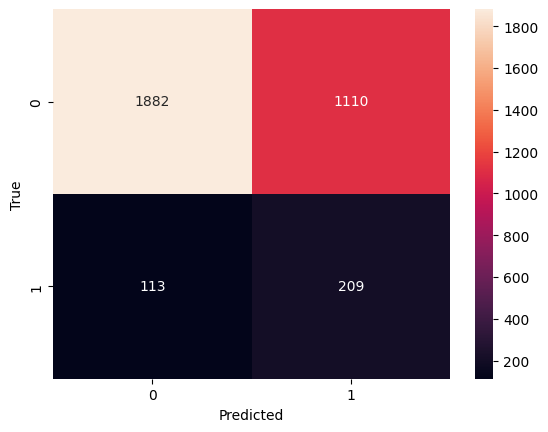

In [44]:
# Plot confusion matrix
sns.heatmap(confusion_matrix(target["csi"], pred), annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')

# Logistic PCA

In [46]:
from LPCA import LogisticPCA

In [47]:
# Check if there any value different from 0 and 1 in X
np.any((X!=0) & (X!=1))

np.False_

In [48]:
lpca = LogisticPCA(m=6, k=10, verbose=True, verbose_interval=10) # Reduce the columns into 10
lpca.fit(X.values, maxiters=50, tol=1e-5)

Iteration: 0
Percent of Deviance Explained: 33.408%
Log Likelihood: -141874.47, Loss Trace: 5.0051740159922105

Iteration: 10
Percent of Deviance Explained: 41.742%
Log Likelihood: -129130.63, Loss Trace: 0.29804980529345926

Iteration: 20
Percent of Deviance Explained: 42.694%
Log Likelihood: -127276.16, Loss Trace: 0.0843008745456757

Iteration: 30
Percent of Deviance Explained: 43.012%
Log Likelihood: -126630.25, Loss Trace: 0.03512955909575055

Iteration: 40
Percent of Deviance Explained: 43.156%
Log Likelihood: -126332.06, Loss Trace: 0.0177890015816331

Training Complete. Converged Reached: False
Percent of Deviance Explained: 43.233 %
Total Training Time: 26.0s


In [49]:
# Transform the data
transformed_X = lpca.transform(X.values)
X_new = lpca.sigmoid(transformed_X)

In [50]:
model = LogisticRegression(class_weight='balanced')
model.fit(X_new, target["csi"])

metrics = print_metrics(target["csi"], model.predict(X_new))

Metrics:
F1 score: 0.8577986700579292
Precision: 0.9244686393622488
Recall: 0.828002414001207
Accuracy: 0.8576327764307303
AUC: 0.8576327764307303
Confusion matrix:
[[2456  536]
 [  34  288]]


In [51]:
# Check what is the best number of components
k_values = range(1, 25)

metrics_list = []

for k in k_values:
    lpca = LogisticPCA(m=6, k=k, verbose=False)
    lpca.fit(X.values, maxiters=50, tol=1e-5)
    transformed_X = lpca.transform(X.values)
    X_new = lpca.sigmoid(transformed_X)
    model = LogisticRegression(class_weight='balanced')
    model.fit(X_new, target["csi"])
    pred = model.predict(X_new)
    metrics = print_metrics(target["csi"], pred)
    metrics_list.append(metrics)

c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics:
F1 score: 0.85673538301406
Precision: 0.8151136580094541
Recall: 0.9028364514182257
Accuracy: 0.5
AUC: 0.5
Confusion matrix:
[[2992    0]
 [ 322    0]]
Metrics:
F1 score: 0.6664164898489991
Precision: 0.8440597180462948
Recall: 0.5814725407362703
Accuracy: 0.5617485136347029
AUC: 0.5617485136347028
Confusion matrix:
[[1754 1238]
 [ 149  173]]
Metrics:
F1 score: 0.7098602693745792
Precision: 0.9106251531775593
Recall: 0.6366928183464092
Accuracy: 0.7655404058856744
AUC: 0.7655404058856744
Confusion matrix:
[[1812 1180]
 [  24  298]]
Metrics:
F1 score: 0.8828672311677671
Precision: 0.9217503522024393
Recall: 0.8636089318044659
Accuracy: 0.8427099594778623
AUC: 0.8427099594778623
Confusion matrix:
[[2599  393]
 [  59  263]]
Metrics:
F1 score: 0.8826120380618773
Precision: 0.922681595079147
Recall: 0.8630054315027158
Accuracy: 0.8465327830737037
AUC: 0.8465327830737037
Confusion matrix:
[[2594  398]
 [  56  266]]
Metrics:
F1 score: 0.8686439828435021
Precision: 0.921385076313595
R

In [52]:
# Select all the F1 score
f1_scores = [metrics['F1 score'] for metrics in metrics_list]
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
recall_scores = [metrics['Recall'] for metrics in metrics_list]

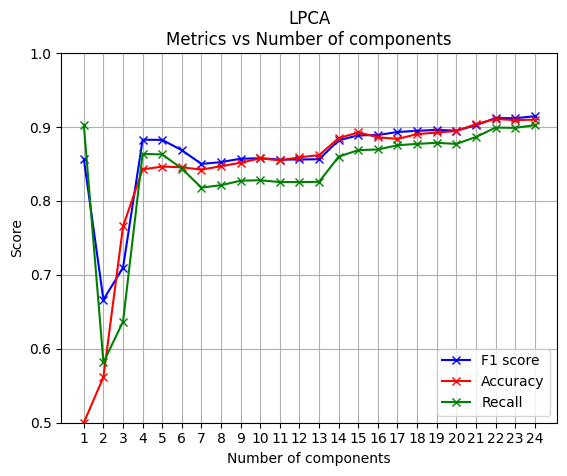

In [53]:
plt.plot(k_values, f1_scores, 'x-', color="blue")
plt.plot(k_values, accuracy_scores, 'x-', color="red")
plt.plot(k_values, recall_scores, 'x-', color="green")
# Xticks equal to k_values
plt.xticks(k_values)
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('LPCA\nMetrics vs Number of components')
plt.legend(['F1 score', 'Accuracy', 'Recall'])
plt.ylim([0.5, 1])
plt.grid()
plt.savefig('../plots/lpca_metrics_vs_k.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [55]:
# Re run for validation set
X["site"] = df["site"]

train_df, val_df, test_df, train_target, val_target, test_target = site_train_val_test_split(X, target, random_state=42)

In [57]:
# Check what is the best number of components
k_values = range(1, 25)

metrics_list = []

for k in k_values:
    lpca = LogisticPCA(m=6, k=k, verbose=False)
    lpca.fit(val_df, maxiters=50, tol=1e-5)
    transformed_X = lpca.transform(val_df)
    X_new = lpca.sigmoid(transformed_X)
    model = LogisticRegression(class_weight='balanced')
    model.fit(X_new, val_target)
    pred = model.predict(X_new)
    metrics = print_metrics(val_target, pred)
    metrics_list.append(metrics)

c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics:
F1 score: 0.8512414800389484
Precision: 0.8082701553254439
Recall: 0.8990384615384616
Accuracy: 0.5
AUC: 0.5
Confusion matrix:
[[374   0]
 [ 42   0]]
Metrics:
F1 score: 0.5644763825244165
Precision: 0.8374971168262022
Recall: 0.47115384615384615
Accuracy: 0.5473644003055768
AUC: 0.5473644003055768
Confusion matrix:
[[169 205]
 [ 15  27]]
Metrics:
F1 score: 0.5736928551875171
Precision: 0.8392626410543543
Recall: 0.4807692307692308
Accuracy: 0.5527119938884645
AUC: 0.5527119938884645
Confusion matrix:
[[173 201]
 [ 15  27]]
Metrics:
F1 score: 0.6699980991002408
Precision: 0.8560564136841138
Recall: 0.5889423076923077
Accuracy: 0.6128724216959511
AUC: 0.6128724216959511
Confusion matrix:
[[218 156]
 [ 15  27]]
Metrics:
F1 score: 0.6759926382877203
Precision: 0.8570404172099088
Recall: 0.5961538461538461
Accuracy: 0.6168831168831169
AUC: 0.6168831168831168
Confusion matrix:
[[221 153]
 [ 15  27]]
Metrics:
F1 score: 0.6585677157232748
Precision: 0.8391796122650125
Recall: 0.574519

In [58]:
# Select all the F1 score
f1_scores = [metrics['F1 score'] for metrics in metrics_list]
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
recall_scores = [metrics['Recall'] for metrics in metrics_list]

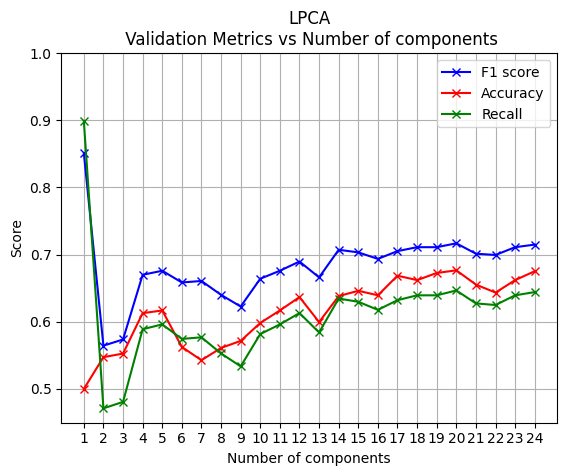

In [60]:
plt.plot(k_values, f1_scores, 'x-', color="blue")
plt.plot(k_values, accuracy_scores, 'x-', color="red")
plt.plot(k_values, recall_scores, 'x-', color="green")
# Xticks equal to k_values
plt.xticks(k_values)
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('LPCA\n Validation Metrics vs Number of components')
plt.legend(['F1 score', 'Accuracy', 'Recall'])
plt.ylim([None, 1])
plt.grid()
plt.savefig('../plots/lpca_metrics_vs_k_val.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [64]:
# Check what is the best number of components
k_values = range(1, 25)

metrics_list = []

for k in k_values:
    lpca = LogisticPCA(m=6, k=k, verbose=False)
    lpca.fit(test_df, maxiters=50, tol=1e-5)
    transformed_X = lpca.transform(test_df)
    X_new = lpca.sigmoid(transformed_X)
    model = LogisticRegression(class_weight='balanced')
    model.fit(X_new, test_target)
    pred = model.predict(X_new)
    metrics = print_metrics(test_target, pred)
    metrics_list.append(metrics)

# Select all the F1 score
f1_scores = [metrics['F1 score'] for metrics in metrics_list]
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
recall_scores = [metrics['Recall'] for metrics in metrics_list]

c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Metrics:
F1 score: 0.8492417527131597
Precision: 0.80578375257432
Recall: 0.8976545842217484
Accuracy: 0.5
AUC: 0.5
Confusion matrix:
[[421   0]
 [ 48   0]]
Metrics:
F1 score: 0.5618696206121029
Precision: 0.8199476711012343
Recall: 0.4669509594882729
Accuracy: 0.5092785035629454
AUC: 0.5092785035629454
Confusion matrix:
[[192 229]
 [ 21  27]]
Metrics:
F1 score: 0.6152891606795367
Precision: 0.8456041504228952
Recall: 0.5266524520255864
Accuracy: 0.5794487331749802
AUC: 0.5794487331749802
Confusion matrix:
[[216 205]
 [ 17  31]]
Metrics:
F1 score: 0.6655804631997927
Precision: 0.8475287877999927
Recall: 0.5842217484008528
Accuracy: 0.5930572050673001
AUC: 0.5930572050673
Confusion matrix:
[[245 176]
 [ 19  29]]
Metrics:
F1 score: 0.716891822091148
Precision: 0.8505568488987669
Recall: 0.6481876332622601
Accuracy: 0.610228622327791
AUC: 0.610228622327791
Confusion matrix:
[[277 144]
 [ 21  27]]
Metrics:
F1 score: 0.7070755185846423
Precision: 0.8548322008086378
Recall: 0.635394456289978

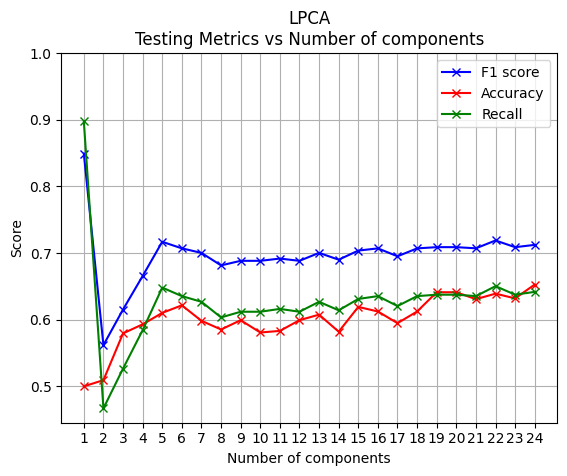

In [65]:
plt.plot(k_values, f1_scores, 'x-', color="blue")
plt.plot(k_values, accuracy_scores, 'x-', color="red")
plt.plot(k_values, recall_scores, 'x-', color="green")
# Xticks equal to k_values
plt.xticks(k_values)
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('LPCA\nTesting Metrics vs Number of components')
plt.legend(['F1 score', 'Accuracy', 'Recall'])
plt.ylim([None, 1])
plt.grid()
plt.savefig('../plots/lpca_metrics_vs_k_test.pdf', dpi=300, bbox_inches='tight')
plt.show()

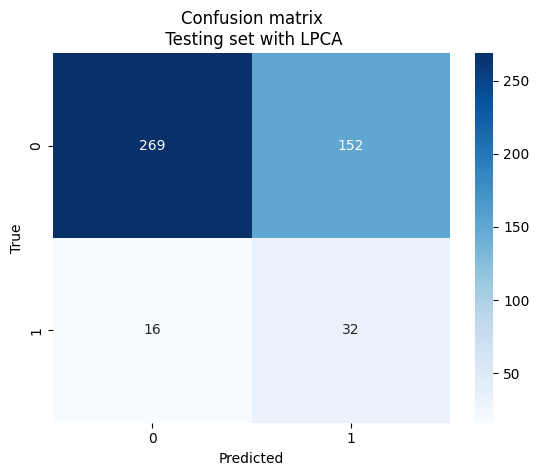

In [70]:
# Confusion matrix
sns.heatmap(confusion_matrix(test_target, pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix\n Testing set with LPCA')
plt.savefig('../plots/lpca_confusion_matrix.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [285]:
# Best k is 15
k = 15
lpca = LogisticPCA(m=5, k=k, verbose=True, verbose_interval=10)
lpca.fit(X.values, maxiters=50, tol=1e-5)
X_new = lpca.sigmoid(lpca.transform(X.values))

# Create new pandas dataframe
df_lpca = pd.DataFrame(X_new, columns=[f'component_{i}' for i in range(k)])
# Add site
df_lpca.loc[:, 'site'] = df.loc[:, 'site']

Iteration: 0
Percent of Deviance Explained: 43.287%
Log Likelihood: -121497.85, Loss Trace: 4.257047417971464

Iteration: 10
Percent of Deviance Explained: 49.543%
Log Likelihood: -112520.62, Loss Trace: 0.1829480848749654

Iteration: 20
Percent of Deviance Explained: 50.114%
Log Likelihood: -111408.33, Loss Trace: 0.04982216102131076

Iteration: 30
Percent of Deviance Explained: 50.302%
Log Likelihood: -111023.09, Loss Trace: 0.02155902178161284

Iteration: 40
Percent of Deviance Explained: 50.394%
Log Likelihood: -110828.59, Loss Trace: 0.012460460000838225

Training Complete. Converged Reached: False
Percent of Deviance Explained: 50.452 %
Total Training Time: 32.0s


In [286]:
df_lpca

,component_0,component_1,component_2,component_3,component_4,component_5,component_6,component_7,component_8,component_9,component_10,component_11,component_12,component_13,component_14,site
0,0.006693,0.522189,0.971576,0.114149,0.039839,0.949227,0.031252,0.006693,0.006693,0.993307,0.986201,0.006693,0.006693,0.006693,0.006693,1
1,0.993307,0.775056,0.023226,0.953356,0.862130,0.993307,0.006693,0.018207,0.228076,0.045621,0.993307,0.006693,0.993307,0.993307,0.006693,1
2,0.993307,0.006693,0.114493,0.009562,0.697720,0.089087,0.170505,0.992737,0.006693,0.967868,0.987539,0.993307,0.993307,0.006693,0.006693,1
3,0.170402,0.086073,0.897140,0.710491,0.009402,0.006693,0.642906,0.991920,0.993307,0.993307,0.090230,0.972174,0.446354,0.993307,0.006693,1
4,0.050887,0.993307,0.984897,0.993307,0.015812,0.274136,0.298722,0.989399,0.219175,0.525478,0.006693,0.006693,0.977839,0.966238,0.006693,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,0.023455,0.992798,0.006693,0.112192,0.006693,0.989742,0.993307,0.034774,0.993307,0.993307,0.710940,0.059661,0.418596,0.993307,0.006693,17
3310,0.926564,0.569572,0.042038,0.580719,0.947913,0.050226,0.993307,0.993307,0.931075,0.993307,0.011143,0.006693,0.993307,0.993307,0.006693,17
3311,0.025451,0.162800,0.992230,0.637909,0.993307,0.006693,0.171668,0.690338,0.006693,0.006693,0.006693,0.023863,0.993307,0.934038,0.006693,17
3312,0.006693,0.955527,0.979015,0.880281,0.988061,0.006693,0.361392,0.611656,0.006693,0.006693,0.006693,0.827957,0.993307,0.987820,0.006693,17


In [292]:
# Split the data into train, validation and test sets
train_df, val_df, test_df, train_target, val_target, test_target = site_train_val_test_split(df_lpca, target, random_state=15)

In [293]:
# Histgradientboosting
from sklearn.ensemble import HistGradientBoostingClassifier

model = HistGradientBoostingClassifier(class_weight='balanced')

model.fit(train_df, train_target)

# Validation
_ = print_metrics(val_target, model.predict(val_df))

Metrics:
F1 score: 0.8713830253395989
Precision: 0.8507759943349463
Recall: 0.8930131004366813
Accuracy: 0.483451536643026
AUC: 0.483451536643026
Confusion matrix:
[[409  14]
 [ 35   0]]


In [294]:
# Test
_ = print_metrics(test_target, model.predict(test_df))

Metrics:
F1 score: 0.8364941718140148
Precision: 0.8119721761423617
Recall: 0.868421052631579
Accuracy: 0.5032014497130776
AUC: 0.5032014497130776
Confusion matrix:
[[624  21]
 [ 74   3]]


In [295]:
# Create Logistic Regression model
model = LogisticRegression(class_weight='balanced')

model.fit(train_df, train_target)

# Validation
_ = print_metrics(val_target, model.predict(val_df))

Metrics:
F1 score: 0.7004522791398413
Precision: 0.8780177009244788
Recall: 0.6091703056768559
Accuracy: 0.578757176629517
AUC: 0.578757176629517
Confusion matrix:
[[260 163]
 [ 16  19]]


In [57]:
# Do standardization
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

train_df_scaled = scaler.fit_transform(train_df)
val_df_scaled = scaler.transform(val_df)
test_df_scaled = scaler.transform(test_df)

In [58]:
model = LogisticRegression(class_weight='balanced')
model.fit(train_df_scaled, train_target)

# Validation
_ = print_metrics(val_target, model.predict(val_df_scaled))

Metrics:
F1 score: 0.6866102912367769
Precision: 0.8082932692307693
Recall: 0.6105769230769231
Accuracy: 0.46638655462184875
AUC: 0.46638655462184864
Confusion matrix:
[[242 132]
 [ 30  12]]


# Sparse L PCA

In [59]:
from sparse_logistic_pca import SparseLogisticPCA

In [60]:
slpca = SparseLogisticPCA(n_components=2)
slpca.fit(X.values, verbose=True)

Iter: 0 - Loss: 0.1965, NegLogLike: 293473.4503, Penalty: 2767.3200 
Iter: 1 - Loss: 0.1629, NegLogLike: 241618.0397, Penalty: 4072.8659 
Iter: 2 - Loss: 0.1500, NegLogLike: 221152.8377, Penalty: 4997.1350 
Iter: 3 - Loss: 0.1433, NegLogLike: 210331.1191, Penalty: 5685.2009 
Iter: 4 - Loss: 0.1391, NegLogLike: 203602.3823, Penalty: 6217.6920 
Iter: 5 - Loss: 0.1364, NegLogLike: 198993.1876, Penalty: 6641.0695 
Iter: 6 - Loss: 0.1344, NegLogLike: 195627.5224, Penalty: 6984.6200 
Iter: 7 - Loss: 0.1329, NegLogLike: 193056.6820, Penalty: 7267.3526 
Iter: 8 - Loss: 0.1317, NegLogLike: 191026.0319, Penalty: 7502.3309 
Iter: 9 - Loss: 0.1307, NegLogLike: 189379.9343, Penalty: 7699.6884 
Iter: 10 - Loss: 0.1299, NegLogLike: 188017.8002, Penalty: 7866.5828 
Iter: 11 - Loss: 0.1292, NegLogLike: 186871.6347, Penalty: 8009.1575 
Iter: 12 - Loss: 0.1287, NegLogLike: 185893.9405, Penalty: 8130.4131 
Iter: 13 - Loss: 0.1282, NegLogLike: 185049.8159, Penalty: 8233.7270 
Iter: 14 - Loss: 0.1278, NegLo

In [61]:
X_new = slpca.transform(X.values)

In [62]:
# Model
model = LogisticRegression(class_weight='balanced')
model.fit(X_new, target["csi"])

metrics = print_metrics(target["csi"], model.predict(X_new))

Metrics:
F1 score: 0.9204064157956656
Precision: 0.9439789906675968
Recall: 0.9100784550392276
Accuracy: 0.9100157355432291
AUC: 0.9100157355432292
Confusion matrix:
[[2723  269]
 [  29  293]]


In [63]:
# Check the best number of components
n_component_values = range(1, 25)

metrics_list = []

for k in k_values:
    slpca = SparseLogisticPCA(n_components=k)
    slpca.fit(X.values, verbose=False)
    X_new = slpca.transform(X.values)
    model = LogisticRegression(class_weight='balanced')
    model.fit(X_new, target["csi"])
    pred = model.predict(X_new)
    metrics = print_metrics(target["csi"], pred)
    metrics_list.append(metrics)

Metrics:
F1 score: 0.6838293258027806
Precision: 0.8393740148313013
Recall: 0.6028968014484007
Accuracy: 0.5486711977281031
AUC: 0.5486711977281031
Confusion matrix:
[[1843 1149]
 [ 167  155]]
Metrics:
F1 score: 0.9204064157956656
Precision: 0.9439789906675968
Recall: 0.9100784550392276
Accuracy: 0.9100157355432291
AUC: 0.9100157355432292
Confusion matrix:
[[2723  269]
 [  29  293]]
Metrics:
F1 score: 0.9218950249270784
Precision: 0.9448576451975227
Recall: 0.9118889559444779
Accuracy: 0.9124040920716112
AUC: 0.9124040920716112
Confusion matrix:
[[2728  264]
 [  28  294]]
Metrics:
F1 score: 0.9226690672067325
Precision: 0.9454547933192117
Recall: 0.9127942063971032
Accuracy: 0.9142911117015977
AUC: 0.9142911117015977
Confusion matrix:
[[2730  262]
 [  27  295]]
Metrics:
F1 score: 0.9245143333563051
Precision: 0.9470568725572915
Recall: 0.9149064574532287
Accuracy: 0.9196179459926264
AUC: 0.9196179459926263
Confusion matrix:
[[2734  258]
 [  24  298]]
Metrics:
F1 score: 0.92963170961670

c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics:
F1 score: 0.9267876596654119
Precision: 0.9485498563585021
Recall: 0.9176222088111045
Accuracy: 0.9238933221509948
AUC: 0.9238933221509947
Confusion matrix:
[[2741  251]
 [  22  300]]


c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics:
F1 score: 0.9254188683818559
Precision: 0.9471387360729859
Recall: 0.9161134580567291
Accuracy: 0.9189007124588966
AUC: 0.9189007124588966
Confusion matrix:
[[2739  253]
 [  25  297]]


c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics:
F1 score: 0.9250773558989979
Precision: 0.9453093489737343
Recall: 0.9161134580567291
Accuracy: 0.9105866160693527
AUC: 0.9105866160693527
Confusion matrix:
[[2745  247]
 [  31  291]]


c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics:
F1 score: 0.9333348416732472
Precision: 0.9513452967703527
Recall: 0.9257694628847315
Accuracy: 0.9284053542365562
AUC: 0.9284053542365563
Confusion matrix:
[[2768  224]
 [  22  300]]


c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics:
F1 score: 0.9351008671909006
Precision: 0.952404178759643
Recall: 0.927881713940857
Accuracy: 0.9309608230644036
AUC: 0.9309608230644036
Confusion matrix:
[[2774  218]
 [  21  301]]


c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics:
F1 score: 0.937365086966239
Precision: 0.953703534501716
Recall: 0.9305974652987327
Accuracy: 0.9338505164911814
AUC: 0.9338505164911814
Confusion matrix:
[[2782  210]
 [  20  302]]


c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics:
F1 score: 0.9382076302355135
Precision: 0.954612974060292
Recall: 0.9315027157513579
Accuracy: 0.9371232188527585
AUC: 0.9371232188527585
Confusion matrix:
[[2783  209]
 [  18  304]]


c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics:
F1 score: 0.9401352588326881
Precision: 0.9552639658464175
Recall: 0.9339167169583584
Accuracy: 0.9370744345168898
AUC: 0.9370744345168898
Confusion matrix:
[[2792  200]
 [  19  303]]


c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics:
F1 score: 0.9057605794280438
Precision: 0.9371210412950465
Recall: 0.8916716958358479
Accuracy: 0.8928934716178962
AUC: 0.8928934716178961
Confusion matrix:
[[2667  325]
 [  34  288]]


c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics:
F1 score: 0.8934717173601177
Precision: 0.93290909164493
Recall: 0.8756789378394689
Accuracy: 0.8826508370146477
AUC: 0.8826508370146477
Confusion matrix:
[[2615  377]
 [  35  287]]


c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics:
F1 score: 0.9309235620577831
Precision: 0.9492016391376906
Recall: 0.9230537115268558
Accuracy: 0.9213586126150064
AUC: 0.9213586126150064
Confusion matrix:
[[2763  229]
 [  26  296]]


c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics:
F1 score: 0.9175556350524599
Precision: 0.942878304276966
Recall: 0.9064574532287266
Accuracy: 0.9080103879496463
AUC: 0.9080103879496463
Confusion matrix:
[[2711  281]
 [  29  293]]


c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics:
F1 score: 0.9159006370917325
Precision: 0.9410621781694573
Recall: 0.9046469523234761
Accuracy: 0.9014649832264922
AUC: 0.9014649832264922
Confusion matrix:
[[2709  283]
 [  33  289]]


c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics:
F1 score: 0.9547656933760301
Precision: 0.965349647792994
Recall: 0.9508147254073627
Accuracy: 0.9616752333344405
AUC: 0.9616752333344405
Confusion matrix:
[[2837  155]
 [   8  314]]


c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Metrics:
F1 score: 0.9169606244909415
Precision: 0.9432514330807574
Recall: 0.9055522027761014
Accuracy: 0.9102804165144318
AUC: 0.9102804165144319
Confusion matrix:
[[2706  286]
 [  27  295]]
Metrics:
F1 score: 0.9221995389594898
Precision: 0.9441189225094021
Recall: 0.9124924562462281
Accuracy: 0.9085812684757697
AUC: 0.9085812684757697
Confusion matrix:
[[2733  259]
 [  31  291]]


c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [64]:
# Select all the F1 score
f1_scores = [metrics['F1 score'] for metrics in metrics_list]
accuracy_scores = [metrics['Accuracy'] for metrics in metrics_list]
recall_scores = [metrics['Recall'] for metrics in metrics_list]

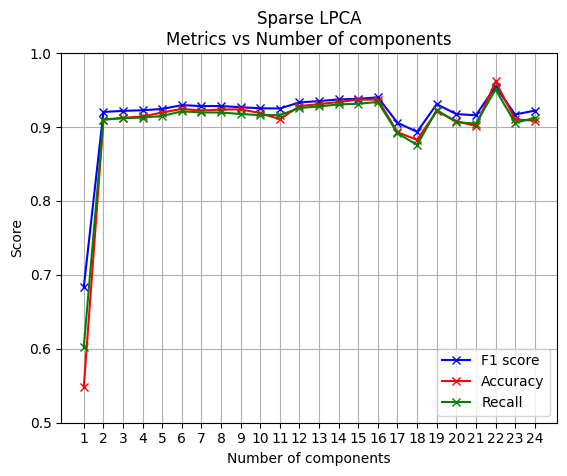

In [65]:
plt.plot(n_component_values, f1_scores, 'x-', color="blue")
plt.plot(n_component_values, accuracy_scores, 'x-', color="red")
plt.plot(n_component_values, recall_scores, 'x-', color="green")
# Xticks equal to k_values
plt.xticks(n_component_values)
plt.xlabel('Number of components')
plt.ylabel('Score')
plt.title('Sparse LPCA\nMetrics vs Number of components')
plt.legend(['F1 score', 'Accuracy', 'Recall'])
plt.ylim([0.5, 1])
plt.grid()
plt.savefig('../plots/slpca_metrics_vs_k.pdf', dpi=300, bbox_inches='tight')
plt.show()

Mean F1 score: 0.9276529936795987


(array([4., 5., 8., 5., 8.]),
 array([0.89636845, 0.90775275, 0.91913704, 0.93052134, 0.94190563,
        0.95328992]),
 <BarContainer object of 5 artists>)

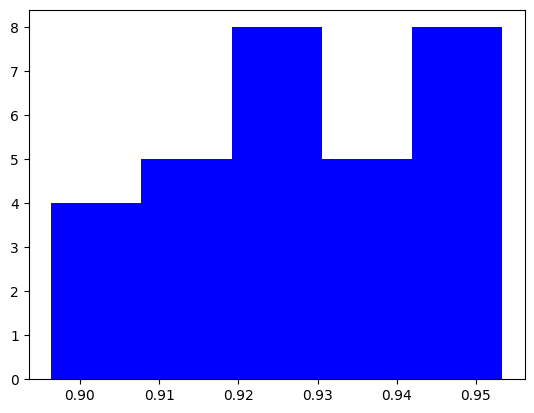

In [66]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
model = LogisticRegression(class_weight='balanced')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

scores = cross_val_score(model, X_new, target["csi"], scoring=balanced_f1, cv=cv, n_jobs=-1)
print('Mean F1 score:', np.mean(scores))
plt.hist(scores, bins=5, color='blue')

In [67]:
# Use n_components = 6

slpca = SparseLogisticPCA(n_components=6)
slpca.fit(X.values, verbose=True)

X_new = slpca.transform(X.values)

# Create a new pandas dataframe
df_sparse_pca = pd.DataFrame(X_new, columns=[f'component_{i}' for i in range(6)])

# Add site to the features
df_sparse_pca.loc[:,'site'] = df.loc[:,'site']

Iter: 0 - Loss: 0.1818, NegLogLike: 268053.0424, Penalty: 6075.8049 
Iter: 1 - Loss: 0.1475, NegLogLike: 213616.5365, Penalty: 8773.8339 
Iter: 2 - Loss: 0.1347, NegLogLike: 192507.6880, Penalty: 10549.8688 
Iter: 3 - Loss: 0.1280, NegLogLike: 181204.8792, Penalty: 11784.4718 
Iter: 4 - Loss: 0.1238, NegLogLike: 174061.8643, Penalty: 12673.4855 
Iter: 5 - Loss: 0.1210, NegLogLike: 169079.9555, Penalty: 13326.2320 
Iter: 6 - Loss: 0.1188, NegLogLike: 165371.7832, Penalty: 13810.9782 
Iter: 7 - Loss: 0.1172, NegLogLike: 162483.5464, Penalty: 14170.7595 
Iter: 8 - Loss: 0.1158, NegLogLike: 160157.6476, Penalty: 14435.2401 
Iter: 9 - Loss: 0.1146, NegLogLike: 158236.9257, Penalty: 14625.7900 
Iter: 10 - Loss: 0.1137, NegLogLike: 156618.6553, Penalty: 14759.2716 
Iter: 11 - Loss: 0.1128, NegLogLike: 155232.9608, Penalty: 14849.3657 
Iter: 12 - Loss: 0.1120, NegLogLike: 154030.1753, Penalty: 14906.8850 
Iter: 13 - Loss: 0.1114, NegLogLike: 152974.3306, Penalty: 14939.6638 
Iter: 14 - Loss: 0

In [68]:
# Separate the data into train, validation and test sets
train_df, val_df, test_df, train_target, val_target, test_target = site_train_val_test_split(df_sparse_pca, target, random_state=42)

In [69]:
# Do Logistic Regression
model = LogisticRegression(class_weight='balanced')

model.fit(train_df, train_target)

# Validation
_ = print_metrics(train_target, model.predict(train_df))

# Test
_ = print_metrics(test_target, model.predict(test_df))

Metrics:
F1 score: 0.6343143556652928
Precision: 0.8451843711584313
Recall: 0.5426101276245369
Accuracy: 0.5543962770549182
AUC: 0.5543962770549182
Confusion matrix:
[[1186 1011]
 [ 100  132]]
Metrics:
F1 score: 0.6045141359371395
Precision: 0.7957202506196667
Recall: 0.509594882729211
Accuracy: 0.44074129057798894
AUC: 0.4407412905779889
Confusion matrix:
[[222 199]
 [ 31  17]]


In [70]:
# Standardize the data
scaler = StandardScaler()

train_df_scaled = scaler.fit_transform(train_df)
val_df_scaled = scaler.transform(val_df)
test_df_scaled = scaler.transform(test_df)

model = LogisticRegression(class_weight='balanced')
model.fit(train_df_scaled, train_target)

# Validation
_ = print_metrics(val_target, model.predict(val_df_scaled))

Metrics:
F1 score: 0.6374203333219727
Precision: 0.8133365927857452
Recall: 0.5480769230769231
Accuracy: 0.4844665138782786
AUC: 0.4844665138782786
Confusion matrix:
[[211 163]
 [ 25  17]]


<Axes: >

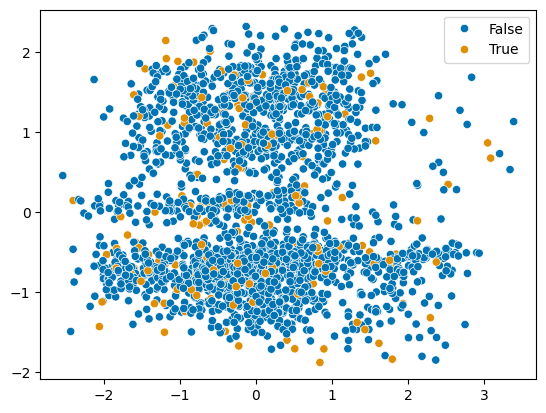

In [71]:
sns.scatterplot(x=train_df_scaled[:,-3], y=train_df_scaled[:,0], hue=train_target)

Mean F1 score: 0.6219569948354362

Validation set:

Metrics:
F1 score: 0.6273597547826623
Precision: 0.8110174735174736
Recall: 0.5360576923076923
Accuracy: 0.47778202189966895
AUC: 0.4777820218996689
Confusion matrix:
[[206 168]
 [ 25  17]]

Test set:

Metrics:
F1 score: 0.6045141359371395
Precision: 0.7957202506196667
Recall: 0.509594882729211
Accuracy: 0.44074129057798894
AUC: 0.4407412905779889
Confusion matrix:
[[222 199]
 [ 31  17]]


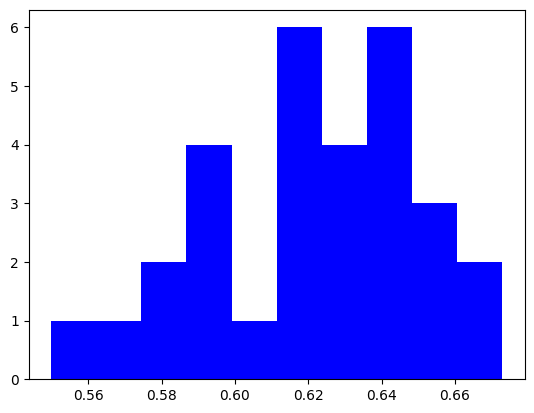

In [72]:
# Perform Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, RepeatedStratifiedKFold
model = LogisticRegression(class_weight='balanced')

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

scores = cross_val_score(model, train_df, train_target, scoring=balanced_f1, cv=cv, n_jobs=-1)
print('Mean F1 score:', scores.mean())
plt.hist(scores, bins=10, color='blue')

# Fit the model
model.fit(train_df, train_target)
print('\nValidation set:\n')
metrics = print_metrics(val_target, model.predict(val_df))
print('\nTest set:\n')
metrics = print_metrics(test_target, model.predict(test_df))

# One hot encoding

In [73]:
# One hot encoding
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()

X_encoded = encoder.fit_transform(X)

In [75]:
# Perform LPCA
lpca = LogisticPCA(m=6, k=20, verbose=True, verbose_interval=10)
lpca.fit(X_encoded.toarray(), maxiters=50, tol=1e-5)

# Transform the data
transformed_X = lpca.transform(X_encoded.toarray())

# Add site
df_lpca = pd.DataFrame(lpca.sigmoid(transformed_X), columns=[f'component_{i}' for i in range(20)])
df_lpca.loc[:,'site'] = df.loc[:,'site']

Iteration: 0
Percent of Deviance Explained: 49.201%
Log Likelihood: -214739.5, Loss Trace: 6.386929131123182

Training Complete. Converged Reached: False
Percent of Deviance Explained: 59.26 %
Total Training Time: 55.0s


In [76]:
# Split the data into train, validation and test sets
train_df, val_df, test_df, train_target, val_target, test_target = site_train_val_test_split(df_lpca, target, random_state=42)

In [77]:
# Perform Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()

model.fit(train_df, train_target)

# Predict the target for the train, validation and test sets
train_pred = model.predict(train_df)
val_pred = model.predict(val_df)
test_pred = model.predict(test_df)

In [78]:
# Print the metrics for the train set
print('Train set:')
train_metrics = print_metrics(train_target, train_pred)

# Print the metrics for the validation set
print('Validation set:')
val_metrics = print_metrics(val_target, val_pred)

# Print the metrics for the test set
print('Test set:')
test_metrics = print_metrics(test_target, test_pred)

Train set:
Metrics:
F1 score: 0.8797769823047614
Precision: 0.9210875101319518
Recall: 0.9135446685878963
Accuracy: 0.5474137931034483
AUC: 0.5474137931034483
Confusion matrix:
[[2197    0]
 [ 210   22]]
Validation set:
Metrics:
F1 score: 0.84883834439672
Precision: 0.8078316610925307
Recall: 0.8942307692307693
Accuracy: 0.49732620320855614
AUC: 0.49732620320855614
Confusion matrix:
[[372   2]
 [ 42   0]]
Test set:
Metrics:
F1 score: 0.8492417527131597
Precision: 0.80578375257432
Recall: 0.8976545842217484
Accuracy: 0.5
AUC: 0.5
Confusion matrix:
[[421   0]
 [ 48   0]]


c:\Users\kurt-\miniconda3\envs\215a\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Use all columns and one hot encoding

In [144]:
df = pd.read_csv('../data/merged_data_cleaned.csv', low_memory=False)

# Drop column
df.drop(columns='injurydatetime', inplace=True)
df.drop(columns=["arrivaldate","arrivaltimend"], inplace=True)
df.drop(columns=["sectiongcsavailable","totalgcsavailable","totalgcsmanual","gcseye","verbalgcs","motorgcs"], inplace=True)

# Get the columns with less and equal that 3 unique values
unique_values = df.nunique()
columns = unique_values[unique_values <= 3].index

# Check if there is Nan values
df.isnull().sum().sum()

# Convert "ND" to Nan
df = df.replace('ND', np.nan)

# Clean the data
df.loc[df["totalgcs"] == "7T","totalgcs"] = 7

# Change the total gcs to numeric
df["totalgcs"] = pd.to_numeric(df["totalgcs"])

In [145]:
df

,site,caseid,controltype,studysubjectid,arrivaltime,modearrival,receivedintransfer,dxcspineinjury,locevalphysician,ptambulatorypriorarrival,...,c7_t1sbligscpl,cspinesignalchange,signalchangelevelc1,signalchangelevelc2,signalchangelevelc3,signalchangelevelc4,signalchangelevelc5,signalchangelevelc6,signalchangelevelc7,cordinjurynoradiographic
0,1,110001,case,110001,22:16,1,0,0,ED,0,...,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,1,110001,ems,120027,17:45,1,0,0,ED,0,...,-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1
2,1,110001,ems,120032,19:58,1,0,0,ED,0,...,-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1
3,1,110001,moi,130058,13:20,1,0,0,ED,0,...,-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1
4,1,110001,moi,130072,16:38,1,0,0,ED,0,...,-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3309,17,1713132,ems,1723178,20:37,1,0,0,ED,0,...,-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1
3310,17,1713132,moi,1733196,18:05,1,0,0,ED,0,...,-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1
3311,17,1713132,moi,1733220,17:05,1,0,0,ED,0,...,-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1
3312,17,1713132,ran,1743311,15:50,1,0,0,ED,0,...,-1.0,-1,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1


In [235]:
# Data
X = df.drop(columns=["caseid", "studysubjectid", "arrivaltime","controltype"])

# Drop any column with object type
X = X.select_dtypes(exclude=['object'])

In [238]:
# One hot encoding using pandas
X_encoded = pd.get_dummies(X, drop_first=True)

In [239]:
# Separate the data into train, validation and test sets
train_df, val_df, test_df, train_target, val_target, test_target = site_train_val_test_split(X_encoded, target, random_state=42)

In [243]:
# HistGradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
model = HistGradientBoostingClassifier(class_weight='balanced')

model.fit(train_df, train_target)

# Predict the target for the train, validation and test sets
train_pred = model.predict(train_df)
val_pred = model.predict(val_df)

# Print the metrics for the train set
print('Train set:')
train_metrics = print_metrics(train_target, train_pred)
print('Validation set:')
val_metrics = print_metrics(val_target, val_pred)

Train set:
Metrics:
F1 score: 0.9903352243903935
Precision: 0.9910456978180321
Recall: 0.9901193906957596
Accuracy: 0.9945380063723259
AUC: 0.9945380063723259
Confusion matrix:
[[2173   24]
 [   0  232]]
Validation set:
Metrics:
F1 score: 0.8387782421313831
Precision: 0.813847592557069
Recall: 0.8677884615384616
Accuracy: 0.49318818436465495
AUC: 0.4931881843646549
Confusion matrix:
[[360  14]
 [ 41   1]]


In [272]:
X_encoded.isnull().sum().sum()

np.int64(136)

In [271]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(class_weight='balanced')

model.fit(train_df, train_target)

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values